# Evaluation Statistics

This notebook generates statistical visualizations from evaluation results stored in MongoDB.

In [1]:
import os
from pymongo import MongoClient
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

## MongoDB Connection Setup

In [2]:
# MongoDB connection configuration
mongo_host = os.getenv("MONGO_HOST", "localhost")
mongo_port = int(os.getenv("MONGO_PORT", "27017"))
mongo_user = os.getenv("MONGO_USER", "root")
mongo_password = os.getenv("MONGO_PASSWORD", "root")

# Create MongoDB connection
mongo_uri = f"mongodb://{mongo_user}:{mongo_password}@{mongo_host}:{mongo_port}/"
client = MongoClient(mongo_uri)
db = client["education"]
evaluation_collection = db["evaluation"]

print(f"Connected to MongoDB at {mongo_host}:{mongo_port}")

Connected to MongoDB at localhost:27017


## Function to Generate Evaluation Statistics

In [3]:
def generate_evaluation_statistics(test_run_id):
    """
    Generate pie charts for evaluation statistics based on test_run_id.
    
    Args:
        test_run_id (str): The test run ID to filter evaluation results
    
    Returns:
        dict: Statistics including counts for each verdict category
    """
    # Query MongoDB for evaluations with the given test_run_id
    results = list(evaluation_collection.find({"test_run_id": test_run_id}))
    
    if not results:
        print(f"No evaluation results found for test_run_id: {test_run_id}")
        return None
    
    print(f"Found {len(results)} evaluation results for test_run_id: {test_run_id}")
    
    # Extract verdicts for correctness and groundedness
    correctness_verdicts = []
    groundedness_verdicts = []
    
    for result in results:
        if "correctness" in result and "verdict" in result["correctness"]:
            correctness_verdicts.append(result["correctness"]["verdict"])
        
        if "groundedness" in result and "verdict" in result["groundedness"]:
            groundedness_verdicts.append(result["groundedness"]["verdict"])
    
    # Debug information
    print(f"Correctness verdicts found: {len(correctness_verdicts)}")
    print(f"Groundedness verdicts found: {len(groundedness_verdicts)}")
    
    if not correctness_verdicts and not groundedness_verdicts:
        print("\nWARNING: No verdicts found in the results!")
        print("Checking first result structure:")
        if results:
            print(f"Sample result keys: {list(results[0].keys())}")
            if "correctness" in results[0]:
                print(f"Correctness keys: {list(results[0]['correctness'].keys())}")
            if "groundedness" in results[0]:
                print(f"Groundedness keys: {list(results[0]['groundedness'].keys())}")
    
    # Count verdicts
    correctness_counts = Counter(correctness_verdicts)
    groundedness_counts = Counter(groundedness_verdicts)
    
    print(f"Correctness counts: {dict(correctness_counts)}")
    print(f"Groundedness counts: {dict(groundedness_counts)}\n")
    
    # Define colors for each verdict category
    colors = {
        "GOOD": "#B4C7E7",  # Light blue
        "SATISFACTORY": "#F4E5A3",  # Light yellow
        "UNSATISFACTORY": "#C27575"  # Light red
    }
    
    # Ensure all categories are present (even if count is 0)
    all_categories = ["GOOD", "SATISFACTORY", "UNSATISFACTORY"]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=400)
    
    # Plot Correctness pie chart
    if correctness_verdicts:
        correctness_labels = []
        correctness_sizes = []
        correctness_colors = []
        
        for category in all_categories:
            count = correctness_counts.get(category, 0)
            if count > 0:
                correctness_labels.append(category)
                correctness_sizes.append(count)
                correctness_colors.append(colors[category])
        
        ax1.pie(correctness_sizes, labels=correctness_labels, autopct='%1.1f%%',
                colors=correctness_colors, startangle=90, textprops={'fontsize': 11})
        ax1.set_title('Correctness Criteria', fontsize=14, pad=20)
    else:
        ax1.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
        ax1.set_title('Correctness Criteria', fontsize=14, pad=20)
    
    # Plot Groundedness pie chart
    if groundedness_verdicts:
        groundedness_labels = []
        groundedness_sizes = []
        groundedness_colors = []
        
        for category in all_categories:
            count = groundedness_counts.get(category, 0)
            if count > 0:
                groundedness_labels.append(category)
                groundedness_sizes.append(count)
                groundedness_colors.append(colors[category])
        
        ax2.pie(groundedness_sizes, labels=groundedness_labels, autopct='%1.1f%%',
                colors=groundedness_colors, startangle=90, textprops={'fontsize': 11})
        ax2.set_title('Groundedness Criteria', fontsize=14, pad=20)
    else:
        ax2.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12)
        ax2.set_title('Groundedness Criteria', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Return statistics
    statistics = {
        "test_run_id": test_run_id,
        "total_evaluations": len(results),
        "correctness": dict(correctness_counts),
        "groundedness": dict(groundedness_counts)
    }
    
    return statistics

## Function to Display Statistics Summary

In [4]:
def display_statistics_summary(statistics):
    """
    Display a summary table of evaluation statistics.
    
    Args:
        statistics (dict): Statistics returned from generate_evaluation_statistics
    """
    if statistics is None:
        return
    
    print("\n" + "="*60)
    print(f"EVALUATION STATISTICS SUMMARY")
    print("="*60)
    print(f"Test Run ID: {statistics['test_run_id']}")
    print(f"Total Evaluations: {statistics['total_evaluations']}")
    print("\n" + "-"*60)
    
    # Correctness summary
    print("\nCORRECTNESS:")
    for verdict, count in statistics['correctness'].items():
        percentage = (count / statistics['total_evaluations']) * 100
        print(f"  {verdict.capitalize()}: {count} ({percentage:.1f}%)")
    
    # Groundedness summary
    print("\nGROUNDEDNESS:")
    for verdict, count in statistics['groundedness'].items():
        percentage = (count / statistics['total_evaluations']) * 100
        print(f"  {verdict.capitalize()}: {count} ({percentage:.1f}%)")
    
    print("\n" + "="*60)

## Function to List All Available Test Run IDs

In [5]:
def list_test_run_ids():
    """
    List all unique test_run_ids in the evaluation collection.
    
    Returns:
        list: List of unique test_run_ids
    """
    test_run_ids = evaluation_collection.distinct("test_run_id")
    
    print("Available Test Run IDs:")
    print("-" * 60)
    for i, test_run_id in enumerate(test_run_ids, 1):
        count = evaluation_collection.count_documents({"test_run_id": test_run_id})
        print(f"{i}. {test_run_id} ({count} evaluations)")
    print("-" * 60)
    
    return test_run_ids

## Example Usage

In [14]:
# List all available test run IDs
test_run_ids = list_test_run_ids()

Available Test Run IDs:
------------------------------------------------------------
1. 5f7f99f8-2420-405b-9491-abb594609ce3 (8 evaluations)
2. 7088e855-c275-4b50-a596-eaa64085293e (8 evaluations)
3. 9d66e0af-c1e0-4f6d-aaee-a9d5013377a6 (8 evaluations)
4. e854d86a-dee2-4ff1-b68c-68314e038e55 (8 evaluations)
------------------------------------------------------------


In [ ]:
# Generate statistics for a specific test_run_id
# Automatically use the first available test_run_id, or specify your own
if test_run_ids and len(test_run_ids) > 0:
    # Use the first test_run_id from the list
    test_run_id = test_run_ids[0]
    print(f"Using test_run_id: {test_run_id}\n")
    
    # Generate charts and get statistics
    stats = generate_evaluation_statistics(test_run_id)
    
    # Display summary
    if stats:
        display_statistics_summary(stats)
else:
    print("No test run IDs found in the database. Please run the evaluator first.")

Found 8 evaluation results for test_run_id: e854d86a-dee2-4ff1-b68c-68314e038e55
Correctness verdicts found: 8
Groundedness verdicts found: 8
Correctness counts: {'GOOD': 7, 'SATISFACTORY': 1}
Groundedness counts: {'GOOD': 7, 'SATISFACTORY': 1}



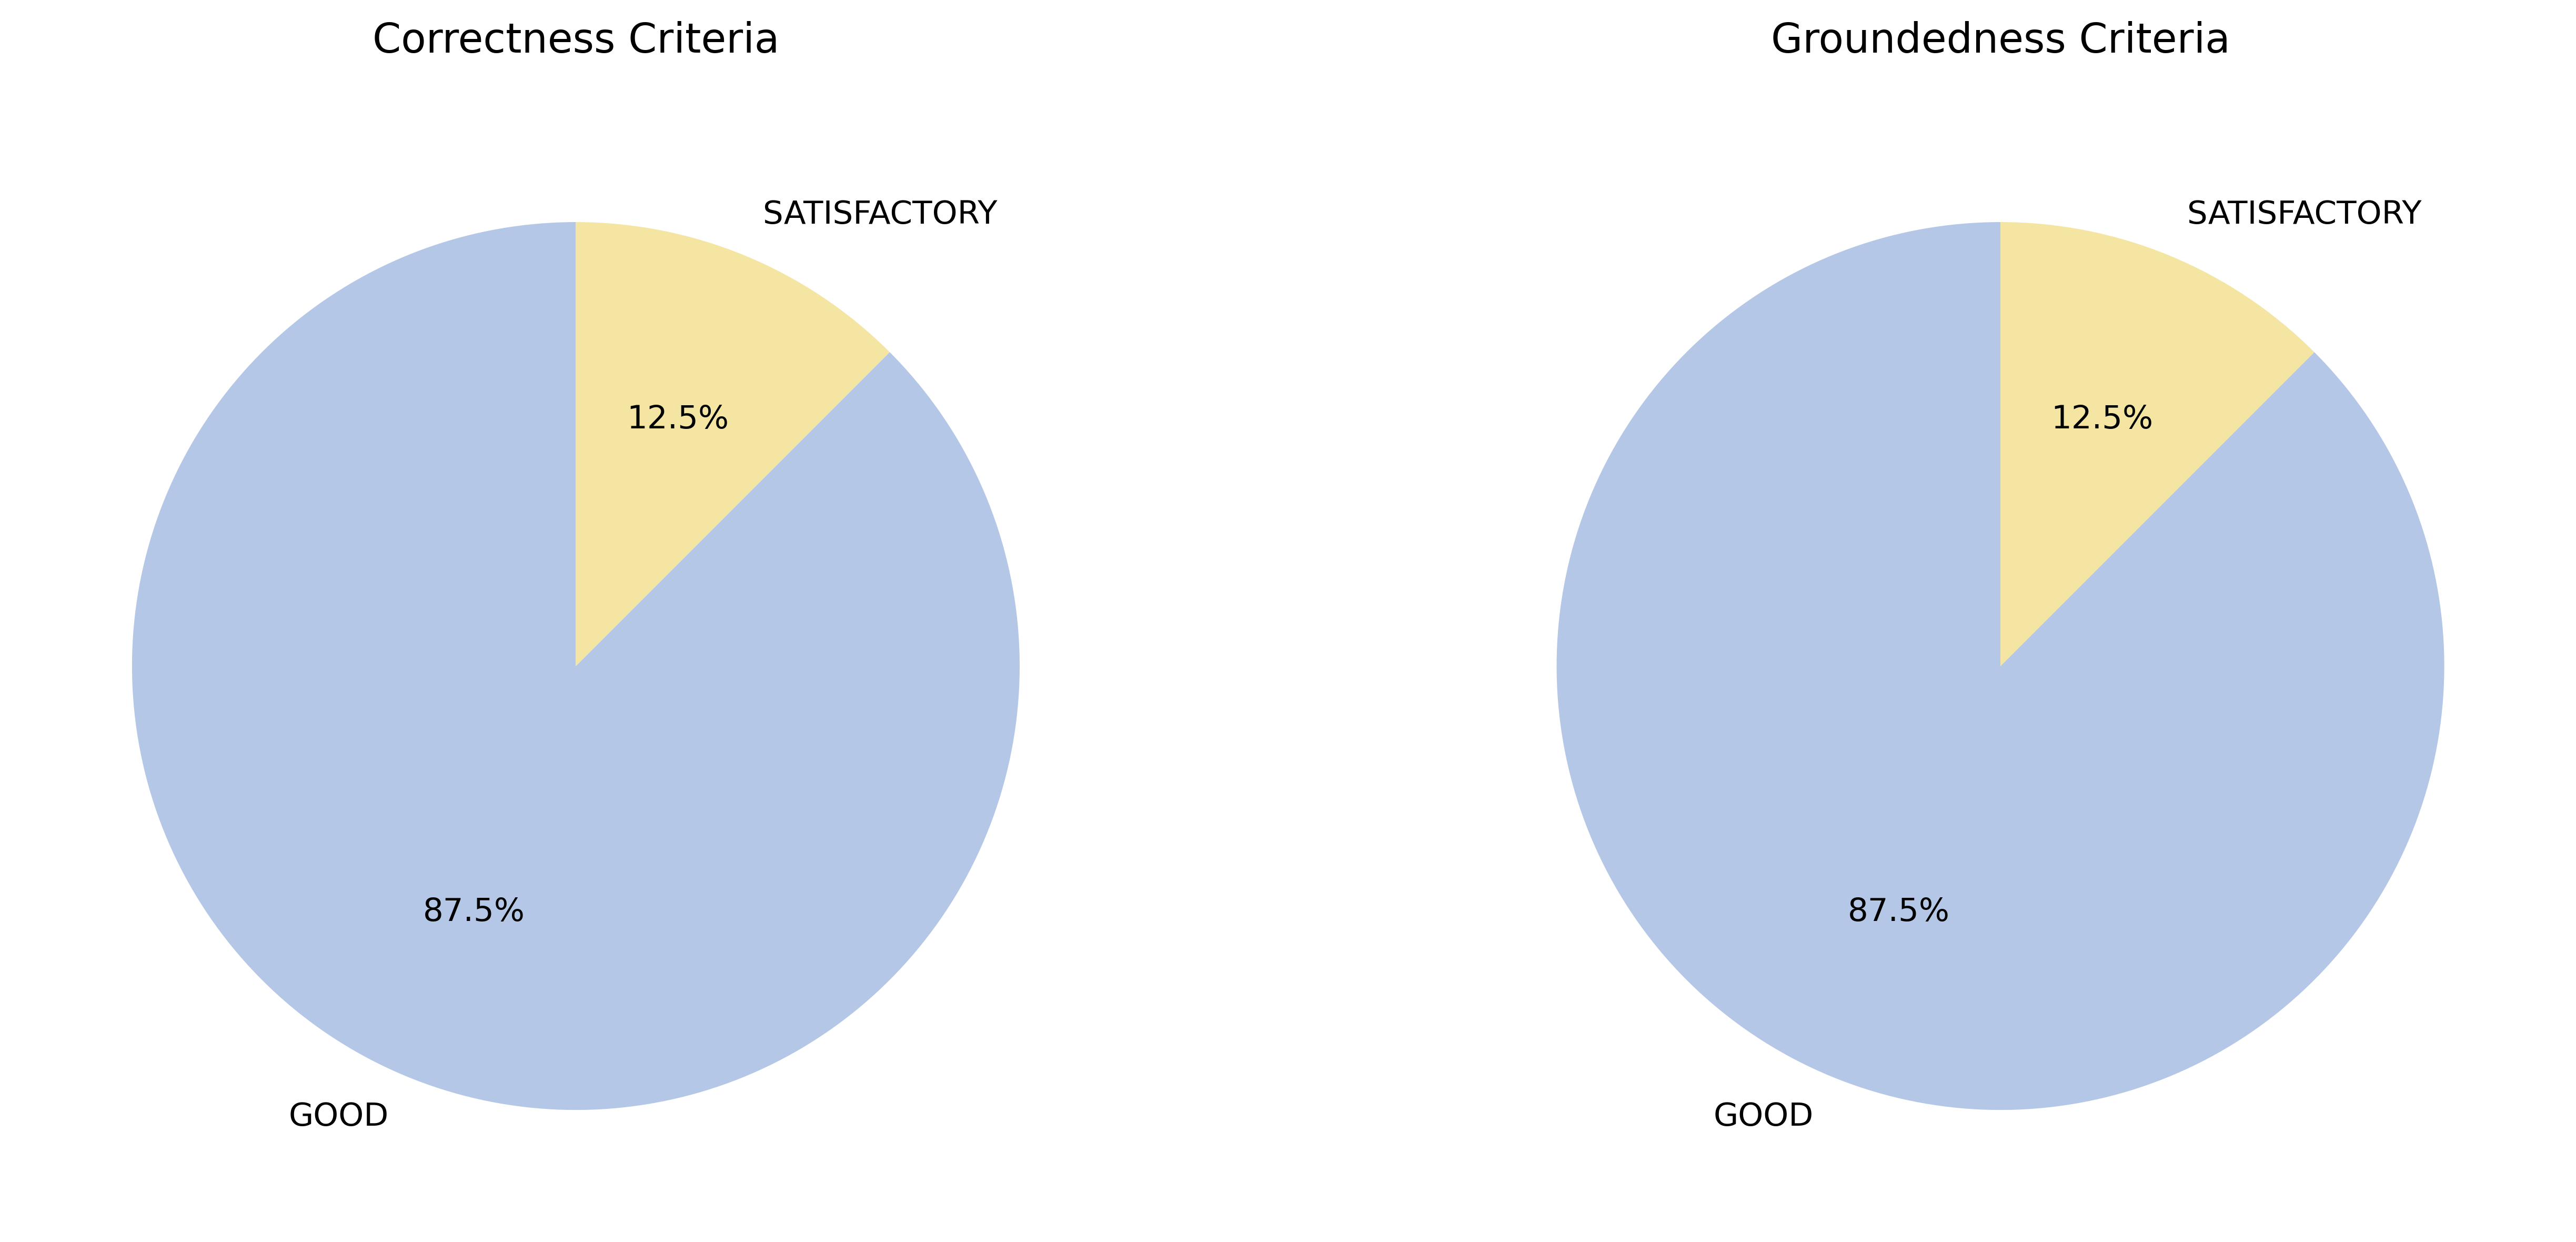


EVALUATION STATISTICS SUMMARY
Test Run ID: e854d86a-dee2-4ff1-b68c-68314e038e55
Total Evaluations: 8

------------------------------------------------------------

CORRECTNESS:
  Good: 7 (87.5%)
  Satisfactory: 1 (12.5%)

GROUNDEDNESS:
  Good: 7 (87.5%)
  Satisfactory: 1 (12.5%)



In [6]:
# Optional: Generate statistics for a specific test_run_id of your choice
# Uncomment and modify the lines below to use a specific test_run_id

custom_test_run_id = "e854d86a-dee2-4ff1-b68c-68314e038e55"  # Replace with your desired test_run_id
stats = generate_evaluation_statistics(custom_test_run_id)
if stats:
    display_statistics_summary(stats)

Found 8 evaluation results for test_run_id: 5f7f99f8-2420-405b-9491-abb594609ce3
Correctness verdicts found: 8
Groundedness verdicts found: 8
Correctness counts: {'GOOD': 5, 'SATISFACTORY': 2, 'UNSATISFACTORY': 1}
Groundedness counts: {'UNSATISFACTORY': 3, 'SATISFACTORY': 3, 'GOOD': 2}



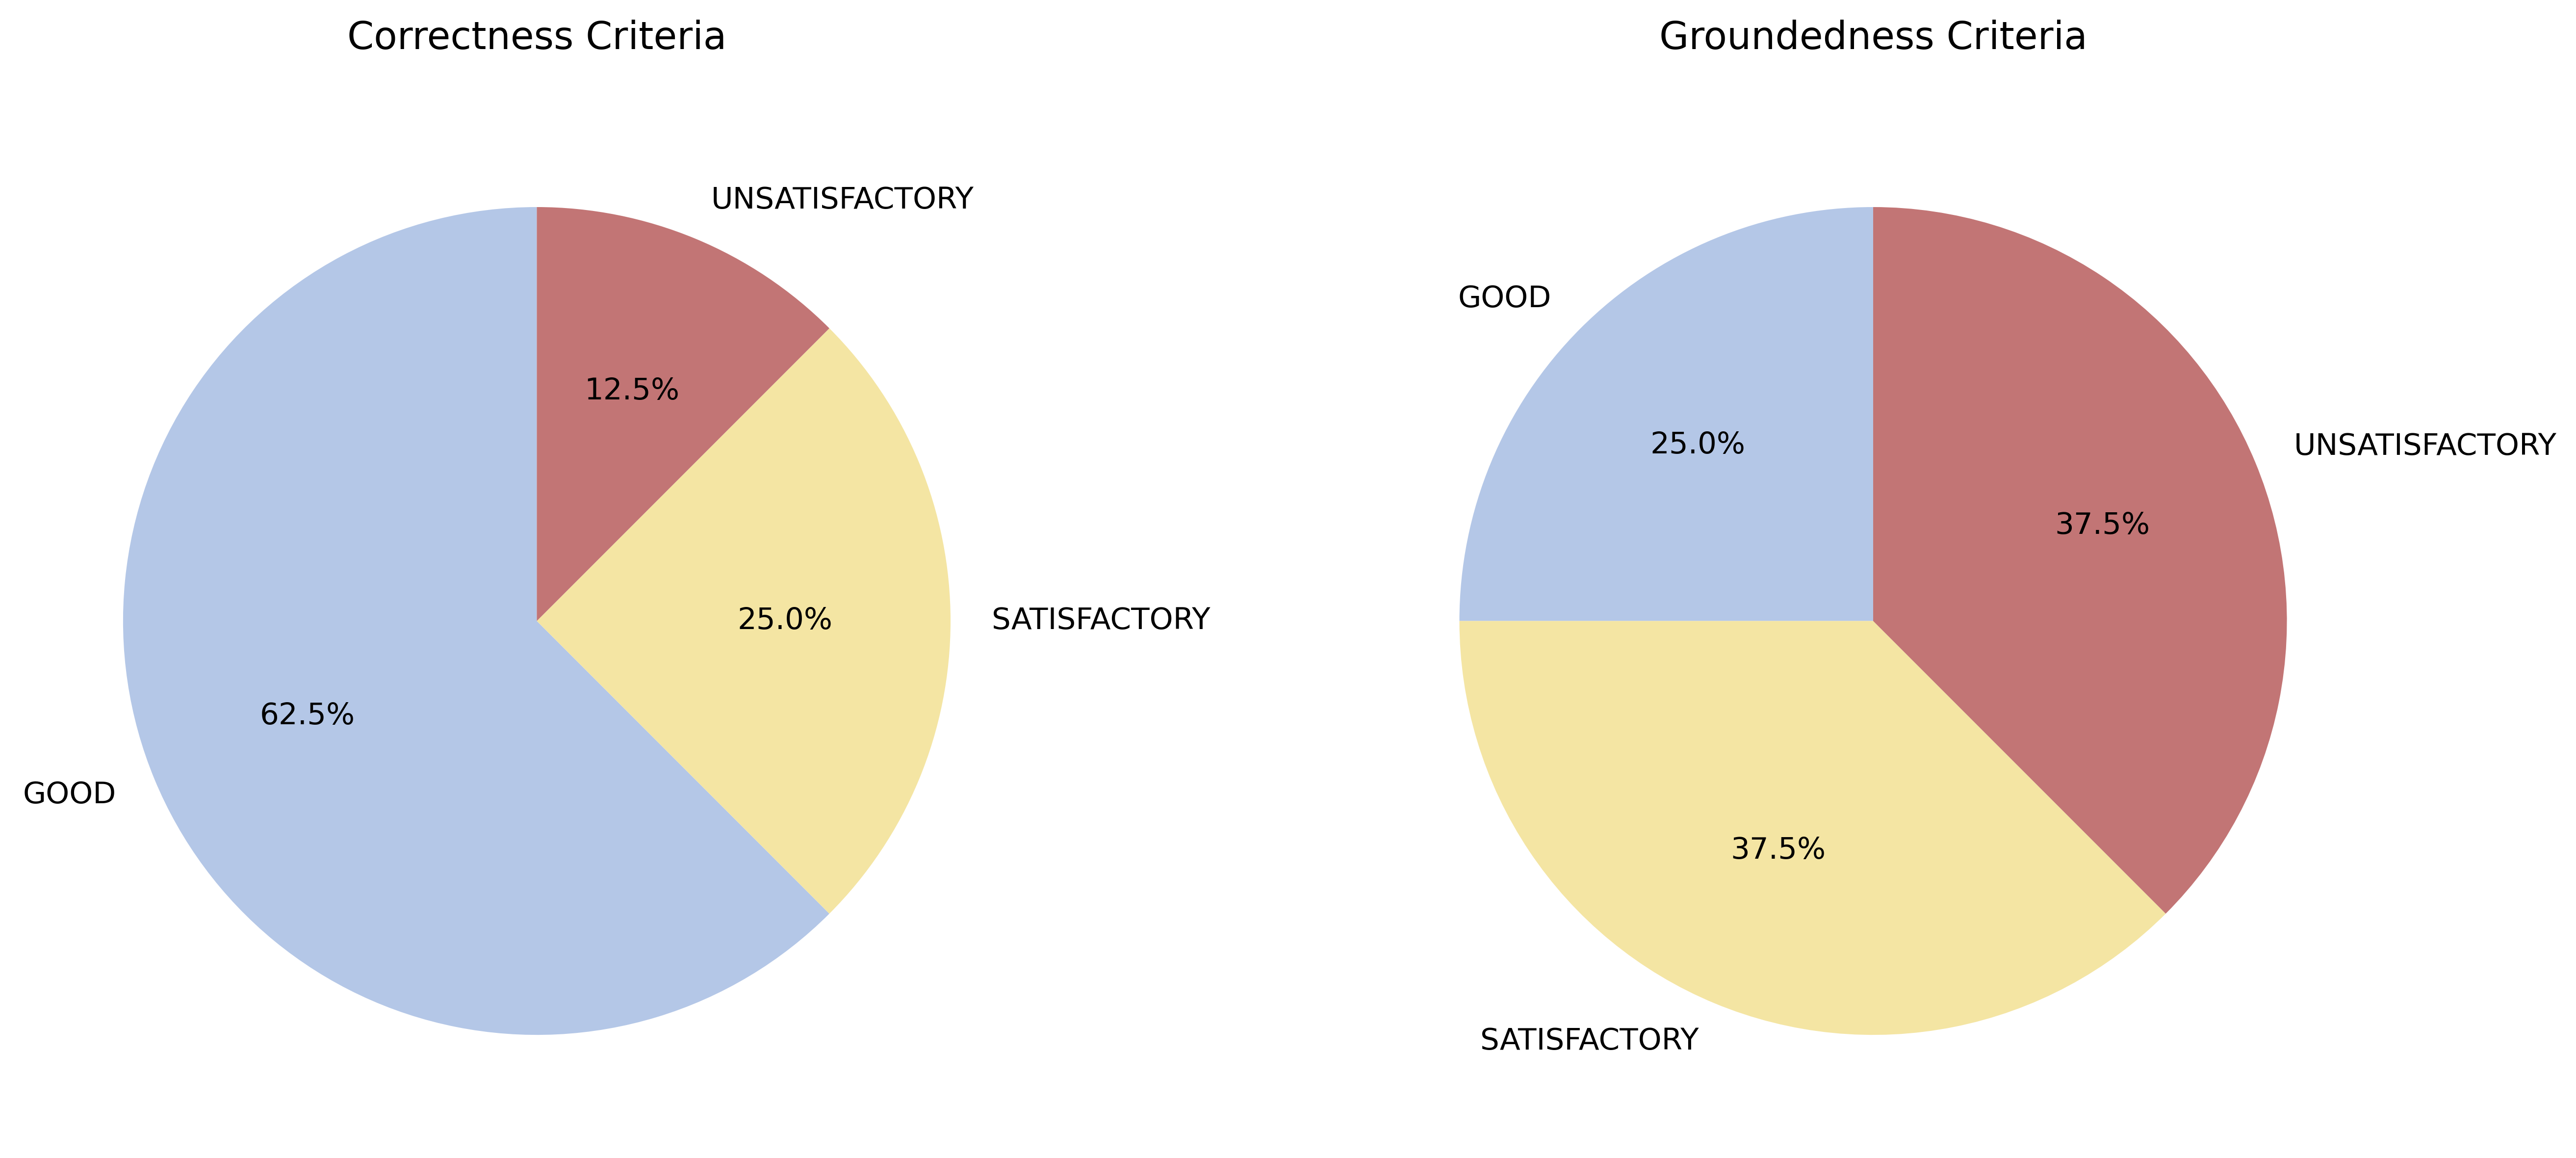


EVALUATION STATISTICS SUMMARY
Test Run ID: 5f7f99f8-2420-405b-9491-abb594609ce3
Total Evaluations: 8

------------------------------------------------------------

CORRECTNESS:
  Good: 5 (62.5%)
  Satisfactory: 2 (25.0%)
  Unsatisfactory: 1 (12.5%)

GROUNDEDNESS:
  Unsatisfactory: 3 (37.5%)
  Satisfactory: 3 (37.5%)
  Good: 2 (25.0%)



In [7]:
custom_test_run_id = "5f7f99f8-2420-405b-9491-abb594609ce3"  # Replace with your desired test_run_id
stats = generate_evaluation_statistics(custom_test_run_id)
if stats:
    display_statistics_summary(stats)

## Compare Multiple Test Runs

In [ ]:
def compare_test_runs(test_run_ids_list):
    """
    Compare multiple test runs side by side.
    
    Args:
        test_run_ids_list (list): List of test_run_ids to compare
    """
    comparison_data = []
    
    for test_run_id in test_run_ids_list:
        results = list(evaluation_collection.find({"test_run_id": test_run_id}))
        
        if not results:
            continue
        
        correctness_verdicts = [r["correctness"]["verdict"] for r in results if "correctness" in r and "verdict" in r["correctness"]]
        groundedness_verdicts = [r["groundedness"]["verdict"] for r in results if "groundedness" in r and "verdict" in r["groundedness"]]
        
        correctness_counts = Counter(correctness_verdicts)
        groundedness_counts = Counter(groundedness_verdicts)
        
        comparison_data.append({
            "Test Run ID": test_run_id[:20] + "..." if len(test_run_id) > 20 else test_run_id,
            "Total": len(results),
            "Correctness Good": correctness_counts.get("good", 0),
            "Correctness Satisfactory": correctness_counts.get("satisfactory", 0),
            "Correctness Unsatisfactory": correctness_counts.get("unsatisfactory", 0),
            "Groundedness Good": groundedness_counts.get("good", 0),
            "Groundedness Satisfactory": groundedness_counts.get("satisfactory", 0),
            "Groundedness Unsatisfactory": groundedness_counts.get("unsatisfactory", 0),
        })
    
    df = pd.DataFrame(comparison_data)
    return df

In [ ]:
# Example: Compare multiple test runs
# Automatically compare all available test runs
if test_run_ids and len(test_run_ids) > 1:
    print(f"Comparing {len(test_run_ids)} test runs...\n")
    comparison_df = compare_test_runs(test_run_ids)
    display(comparison_df)
elif test_run_ids and len(test_run_ids) == 1:
    print("Only one test run available. Need at least 2 test runs to compare.")
else:
    print("No test runs available for comparison.")

## Close MongoDB Connection

In [ ]:
# Close the MongoDB connection when done
client.close()
print("MongoDB connection closed.")